In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization
import matplotlib as mpl

from sklearn.linear_model import LinearRegression # linear regression
from sklearn.model_selection import train_test_split # split up data set for train test
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
mpl.rcParams['agg.path.chunksize'] = 10000
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/us-traffic-2015/dot_traffic_2015.txt.gz
/kaggle/input/us-traffic-2015/dot_traffic_stations_2015.txt.gz


**Exploring the data**

In [4]:
data = pd.read_csv('../input/us-traffic-2015/dot_traffic_2015.txt.gz')
pd.set_option('display.max_columns', None)
data.head(10)

,date,day_of_data,day_of_week,direction_of_travel,direction_of_travel_name,fips_state_code,functional_classification,functional_classification_name,lane_of_travel,month_of_data,record_type,restrictions,station_id,traffic_volume_counted_after_0000_to_0100,traffic_volume_counted_after_0100_to_0200,traffic_volume_counted_after_0200_to_0300,traffic_volume_counted_after_0300_to_0400,traffic_volume_counted_after_0400_to_0500,traffic_volume_counted_after_0500_to_0600,traffic_volume_counted_after_0600_to_0700,traffic_volume_counted_after_0700_to_0800,traffic_volume_counted_after_0800_to_0900,traffic_volume_counted_after_0900_to_1000,traffic_volume_counted_after_1000_to_1100,traffic_volume_counted_after_1100_to_1200,traffic_volume_counted_after_1200_to_1300,traffic_volume_counted_after_1300_to_1400,traffic_volume_counted_after_1400_to_1500,traffic_volume_counted_after_1500_to_1600,traffic_volume_counted_after_1600_to_1700,traffic_volume_counted_after_1700_to_1800,traffic_volume_counted_after_1800_to_1900,traffic_volume_counted_after_1900_to_2000,traffic_volume_counted_after_2000_to_2100,traffic_volume_counted_after_2100_to_2200,traffic_volume_counted_after_2200_to_2300,traffic_volume_counted_after_2300_to_2400,year_of_data
0,2015-04-07,7,3,1,North,56,3R,Rural: Principal Arterial - Other,1,4,3,NaN,000084,4,3,2,4,43,78,116,144,132,115,150,184,169,136,129,89,122,124,110,69,73,28,12,6,15
1,2015-09-26,26,7,7,West,21,1U,Urban: Principal Arterial - Interstate,2,9,3,NaN,056P94,381,252,218,194,220,348,453,679,826,962,1158,1379,1376,1383,1453,1617,1669,1308,1068,928,885,798,650,613,15
2,2015-06-16,16,3,3,East,6,1U,Urban: Principal Arterial - Interstate,0,6,3,NaN,077590,585,408,328,364,696,1929,4228,5634,5673,4636,3925,3827,4049,3954,4077,4244,4405,4609,4361,3272,2243,2050,1453,892,15
3,2015-04-26,26,1,5,South,55,1U,Urban: Principal Arterial - Interstate,1,4,3,NaN,450001,105,73,68,66,77,113,254,367,487,668,870,996,1003,1000,1043,1011,959,851,708,559,457,297,207,110,15
4,2015-05-23,23,7,3,East,4,4R,Rural: Minor Arterial,0,5,3,NaN,102210,6,4,2,3,1,10,17,52,64,68,82,96,99,87,87,83,61,55,35,29,21,23,9,7,15
5,2015-07-25,25,7,5,South,44,2U,Urban: Principal Arterial - Other Freeways or ...,0,7,3,NaN,008148,1168,781,738,425,279,395,715,1202,1486,1819,2193,2401,2691,2508,2700,2673,2746,2564,2257,2140,2060,2156,1873,1590,15
6,2015-09-10,10,5,3,East,19,3U,Urban: Principal Arterial - Other,2,9,3,NaN,000823,34,43,27,48,88,269,334,476,444,355,375,434,492,499,539,542,571,559,395,351,262,217,153,61,15
7,2015-10-27,27,3,3,East,36,4U,Urban: Minor Arterial,1,10,3,NaN,009582,13,3,8,3,17,47,95,158,151,151,141,184,193,219,217,238,278,250,154,130,84,56,21,14,15
8,2015-06-26,26,6,7,West,42,1R,Rural: Principal Arterial - Interstate,2,6,3,NaN,000393,115,78,31,40,42,134,268,335,392,441,600,722,652,706,751,740,784,822,703,425,192,159,150,168,15
9,2015-05-12,12,3,5,South,40,2U,Urban: Principal Arterial - Other Freeways or ...,2,5,3,NaN,AVC068,189,100,115,108,219,527,1212,1596,1347,1115,1114,1126,1178,1193,1364,1662,1673,1519,1148,914,808,555,468,270,15


Seems like there are a lot of columns

There appears to be a number of columns binning traffic volume hourly.

There are also two columns that appear to be related to each other - functional_classification, functional_classification_name. 

In modeling, we can probably do away with one of these.

**Data Checks**

check for NA 

In [5]:
data.isna().any(axis=0)

date                                         False
day_of_data                                  False
day_of_week                                  False
direction_of_travel                          False
direction_of_travel_name                     False
fips_state_code                              False
functional_classification                    False
functional_classification_name               False
lane_of_travel                               False
month_of_data                                False
record_type                                  False
restrictions                                  True
station_id                                   False
traffic_volume_counted_after_0000_to_0100    False
traffic_volume_counted_after_0100_to_0200    False
traffic_volume_counted_after_0200_to_0300    False
traffic_volume_counted_after_0300_to_0400    False
traffic_volume_counted_after_0400_to_0500    False
traffic_volume_counted_after_0500_to_0600    False
traffic_volume_counted_after_06

Appears that the restrictions column is a dead column full of NaN, not able to derive any useful information

In [6]:
data['restrictions'].notna().any()

False

In [7]:
stations = pd.read_csv('../input/us-traffic-2015/dot_traffic_stations_2015.txt.gz')
stations.head(10)

,algorithm_of_vehicle_classification,algorithm_of_vehicle_classification_name,calibration_of_weighing_system,calibration_of_weighing_system_name,classification_system_for_vehicle_classification,concurrent_route_signing,concurrent_signed_route_number,direction_of_travel,direction_of_travel_name,fips_county_code,fips_state_code,functional_classification,functional_classification_name,hpms_sample_identifier,hpms_sample_type,lane_of_travel,lane_of_travel_name,latitude,longitude,lrs_identification,lrs_location_point,method_of_data_retrieval,method_of_data_retrieval_name,method_of_traffic_volume_counting,method_of_traffic_volume_counting_name,method_of_truck_weighing,method_of_truck_weighing_name,method_of_vehicle_classification,method_of_vehicle_classification_name,national_highway_system,number_of_lanes_in_direction_indicated,number_of_lanes_monitored_for_traffic_volume,number_of_lanes_monitored_for_truck_weight,number_of_lanes_monitored_for_vehicle_class,posted_route_signing,posted_signed_route_number,previous_station_id,primary_purpose,primary_purpose_name,record_type,sample_type_for_traffic_volume,sample_type_for_traffic_volume_name,sample_type_for_truck_weight,sample_type_for_truck_weight_name,sample_type_for_vehicle_classification,sample_type_for_vehicle_classification_name,second_type_of_sensor,shrp_site_identification,station_id,station_location,type_of_sensor,type_of_sensor_name,year_of_data,year_station_discontinued,year_station_established
0,NaN,NaN,NaN,NaN,13,3,091,7,West,59,6,2U,Urban: Principal Arterial - Other Freeways or ...,NaN,N,4,Other lanes,33.850898,117.814391,00000000091R,NaN,2,Automated (telemetry),3,Permanent automatic traffic recorder (ATR),0,NaN,0,NaN,Y,5,5,0,0,3,091,NaN,P,Planning or traffic statistics purposes,S,T,Station used for Traffic Volume Trends,NaN,NaN,N,Station not used for Heavy Vehicle Travel Info...,N,NaN,129130,LAKEVIEW AVENUE ORA91R10.091,L,Inductance loop,15,0,97
1,NaN,NaN,NaN,NaN,13,3,099,5,South,77,6,3R,Rural: Principal Arterial - Other,NaN,N,1,Outside (rightmost) lane,37.874697,121.219590,00000000099R,248336.0,2,Automated (telemetry),3,Permanent automatic traffic recorder (ATR),0,NaN,0,NaN,Y,2,2,0,0,3,099,NaN,P,Planning or traffic statistics purposes,S,T,Station used for Traffic Volume Trends,NaN,NaN,N,Station not used for Heavy Vehicle Travel Info...,N,NaN,100190,LITTLE JOHN CREEK SJ9912.526,L,Inductance loop,15,0,97
2,G,Axle spacing with Scheme F modified,NaN,NaN,15,1,005,1,North,93,6,1R,Rural: Principal Arterial - Interstate,NaN,N,2,Other lanes,41.441777,122.435010,00000000005R,750293.0,2,Automated (telemetry),3,Permanent automatic traffic recorder (ATR),0,NaN,3,Permanent vehicle classification device,Y,2,2,0,2,1,005,NaN,P,Planning or traffic statistics purposes,S,T,Station used for Traffic Volume Trends,NaN,NaN,H,Station used for Heavy Vehicle Travel Informat...,N,NaN,022940,EDGEWOOD SIS5R22.999,P,Piezoelectric,15,0,69
3,D,Vehicle length classification,M,Moving average of the steering axle of 3S2s,13,0,NaN,5,South,35,49,1U,Urban: Principal Arterial - Interstate,A00015293910,Y,1,Outside (rightmost) lane,40.516500,111.891520,000000001500,290600.0,2,Automated (telemetry),3,Permanent automatic traffic recorder (ATR),4,Portable weigh-in-motion system,3,Permanent vehicle classification device,Y,5,5,5,5,1,15,NaN,P,Planning or traffic statistics purposes,S,T,Station used for Traffic Volume Trends,B,Station used for TMG sample and Strategic High...,N,Station not used for Heavy Vehicle Travel Info...,NaN,NaN,000302,I 15 12900 South M.P. 290.6,X,Radio wave,15,0,11
4,G,Axle spacing with Scheme F modified,0,NaN,14,1,000000,7,West,27,34,1U,Urban: Principal Arterial - Interstate,NaN,N,4,Other lanes,40.892373,74.484206,NaN,NaN,2,Automated (telemetry),2,Portable traffic recording device,0,NaN,3,Permanent vehicle classification device,Y,4,4,4,4,1,000080,NaN,P,Planning or traffic statistics purposes,S,T,Station used for Traffic Volume Trends,N,Station not used for any of the above,N,Station not used f

Plotting the distributions of rides throughout the week, we can distinctly see 2 patterns:

1. Most days follow a bimodal distribution of rides, peaking at about 7-9 AM  in the morning, and around 4-6 PM in the evening. These correspond to when most workers have to get to and from work. 

2. Only 2 days deviate from this trend, which we can identify as the weekends. The weekends follow a much more bell shaped destribution in the number of rides, as the majority of people are not commuting to and from work anymore.

It is also observed that the evening peak traffic volume is slightly higher than that in the morning.

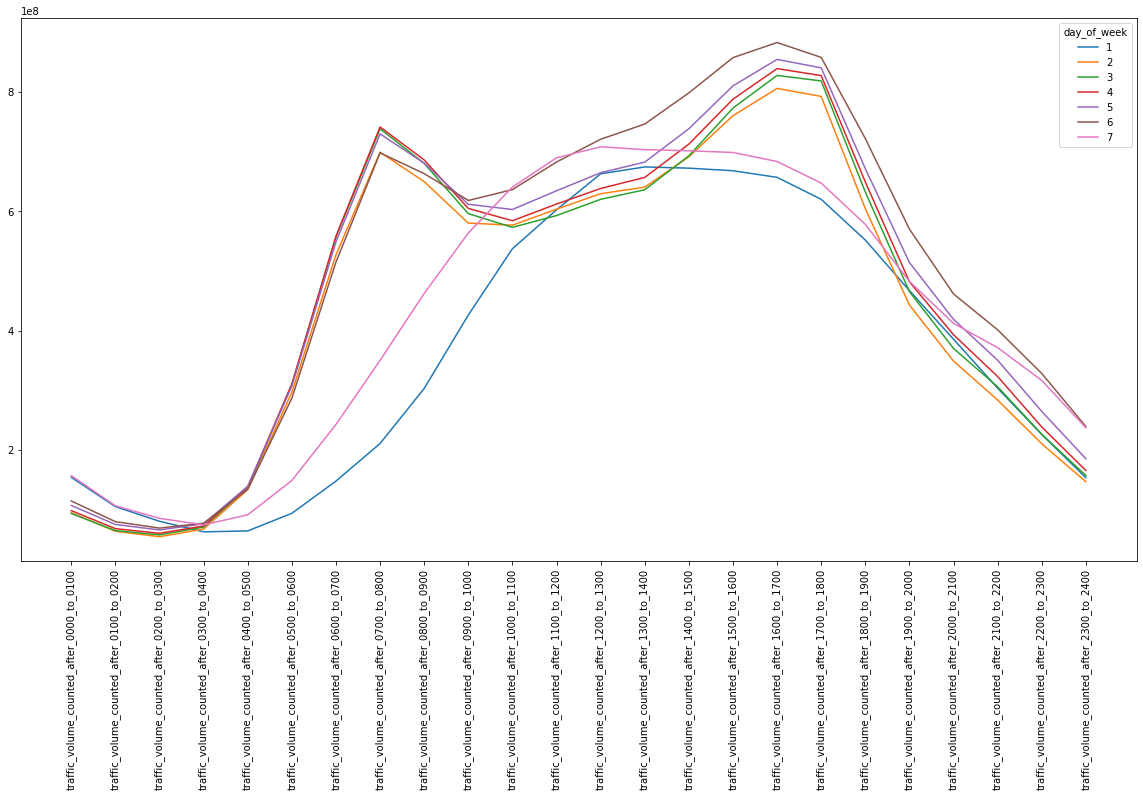

In [8]:
def allRoads():
#     use a function to cutback on memory
    dayData=data.groupby(['day_of_week']).sum().iloc[:,7:-1]
    ax=dayData.T.plot(figsize=(20,10),xticks=range(0,24),rot=90)
    # group by day of week, transpose and plot out by day
    
allRoads()

Breaking the data downby the types of roads, we see that most road types follow a similar behaviour, with a bimodal distribution on weekdays.

However, it is noticed that for the Rural Interstate, the bimodal distribution is not as pronounced. Urban Interstate roads on the other hand still has a bimodal distribution for traffic volume. This suggests that in rural areas, the interstate roads are not heavily used for getting to and from work.

We also can see an anomaly for urban local systems on Tuesdays with two sudden large spikes in traffic volume.

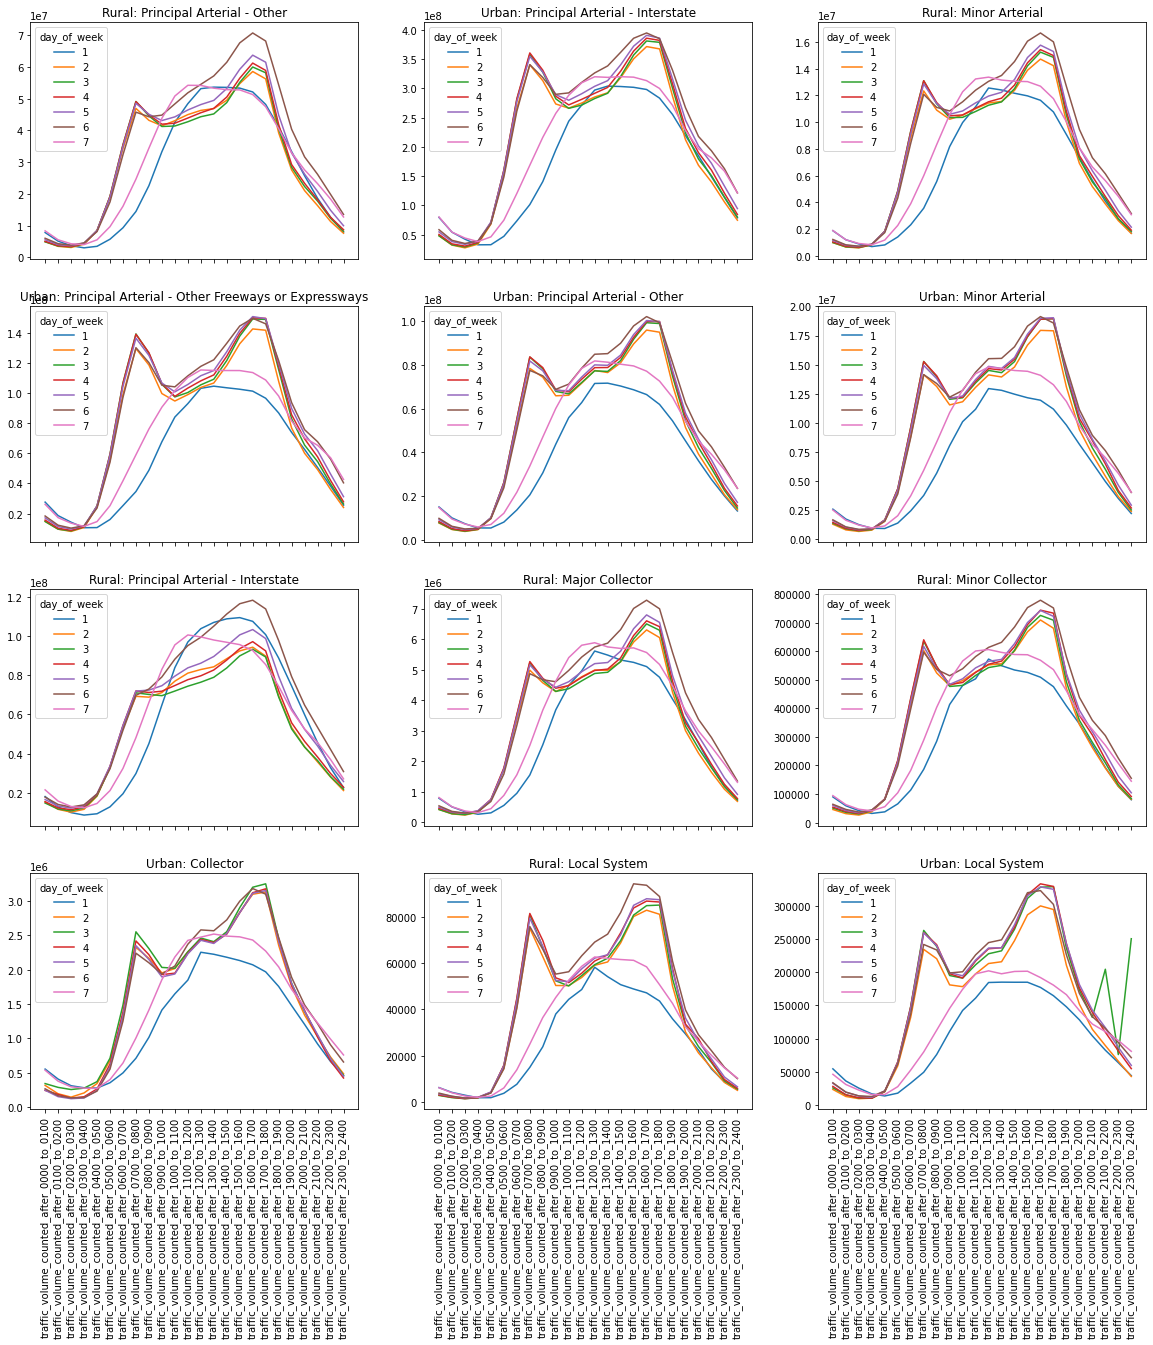

In [9]:
roadCats=data['functional_classification_name'].unique()
# categories of road
def trafficsub(data):
# create a function to do splitting by functional category of road
    funcDayData=data.groupby(['functional_classification_name','day_of_week']).sum().iloc[:,7:-1]
#     group by unctional class and day of week    
    fig, axs=plt.subplots(4, 3, figsize=(20,20), sharex=True)
    for num,ax in enumerate(axs.flat):
        funcDayData.unstack(level=1).T.unstack()[roadCats[num]].plot(ax=ax,xticks=range(0,24),title=roadCats[num],rot=90)

trafficsub(data)

To examine the anomalous data, we split out the dataset and take a closer look.

Plotting a histogram, we see that there appears to be two rows containining outlier points. 

Sorting by value shows a few readings of 99999, which suggests that we should indeed omit these 2 points, as there appears to be some sort of technical error on the data.

Both readings were captured at the same station on the same day, but in opposite directions (East vs West), further indicating that there may have been some fault with the equipment that day.

As this value is relatively small ($10^6$) compared to total traffic flow ($10^8$), or approximately 1%, this did not show up when plotting the aggrated data for all road types at once initially.


In [10]:
splitDat=data[(data['day_of_week'] == 3) & (data['functional_classification_name'] == 'Urban: Local System')]
# split out data
# create a list of indexes to drop
dropidx=splitDat[splitDat['traffic_volume_counted_after_2300_to_2400']==99999].index.to_list()
# display data
splitDat.sort_values('traffic_volume_counted_after_2300_to_2400',ascending=False).head(5)


,date,day_of_data,day_of_week,direction_of_travel,direction_of_travel_name,fips_state_code,functional_classification,functional_classification_name,lane_of_travel,month_of_data,record_type,restrictions,station_id,traffic_volume_counted_after_0000_to_0100,traffic_volume_counted_after_0100_to_0200,traffic_volume_counted_after_0200_to_0300,traffic_volume_counted_after_0300_to_0400,traffic_volume_counted_after_0400_to_0500,traffic_volume_counted_after_0500_to_0600,traffic_volume_counted_after_0600_to_0700,traffic_volume_counted_after_0700_to_0800,traffic_volume_counted_after_0800_to_0900,traffic_volume_counted_after_0900_to_1000,traffic_volume_counted_after_1000_to_1100,traffic_volume_counted_after_1100_to_1200,traffic_volume_counted_after_1200_to_1300,traffic_volume_counted_after_1300_to_1400,traffic_volume_counted_after_1400_to_1500,traffic_volume_counted_after_1500_to_1600,traffic_volume_counted_after_1600_to_1700,traffic_volume_counted_after_1700_to_1800,traffic_volume_counted_after_1800_to_1900,traffic_volume_counted_after_1900_to_2000,traffic_volume_counted_after_2000_to_2100,traffic_volume_counted_after_2100_to_2200,traffic_volume_counted_after_2200_to_2300,traffic_volume_counted_after_2300_to_2400,year_of_data
6203794,2015-09-08,8,3,3,East,13,7U,Urban: Local System,1,9,3,NaN,000044,6,4,2,1,3,10,32,68,37,38,35,34,41,43,47,57,64,67,60,51,37,99999,23,99999,15
6740188,2015-09-08,8,3,7,West,13,7U,Urban: Local System,1,9,3,NaN,000044,9,4,2,0,3,8,20,61,29,18,29,32,35,33,50,61,54,68,58,42,35,67,12,99999,15
4913841,2015-01-06,6,3,5,South,36,7U,Urban: Local System,2,1,3,NaN,000283,85,34,18,23,23,154,223,299,128,248,380,333,354,227,286,375,334,287,298,284,168,171,170,354,15
1539574,2015-03-03,3,3,5,South,36,7U,Urban: Local System,2,3,3,NaN,000283,107,39,15,20,41,80,216,258,220,252,358,335,352,329,256,363,427,392,389,383,345,436,364,321,15
6782943,2015-06-23,23,3,1,North,36,7U,Urban: Local System,1,6,3,NaN,000283,63,43,27,14,18,92,118,203,299,285,261,296,282,283,282,379,419,418,492,481,271,213,324,256,15


In [11]:
splitDat['traffic_volume_counted_after_2300_to_2400'].describe()

count     1515.00000
mean       165.50033
std       3631.13213
min          0.00000
25%          6.00000
50%         19.00000
75%         46.00000
max      99999.00000
Name: traffic_volume_counted_after_2300_to_2400, dtype: float64

**Checking for other anomalous data**

To do checks on other outlier points that may skew the normal daya to day variation, we can simply examine the summary statistics.

It is noted that all the columns have values starting from less than 0.

We also observe that 99999 maximum value is also reported for a number of columns.




In [12]:
data.iloc[:,13:-1].describe()

,traffic_volume_counted_after_0000_to_0100,traffic_volume_counted_after_0100_to_0200,traffic_volume_counted_after_0200_to_0300,traffic_volume_counted_after_0300_to_0400,traffic_volume_counted_after_0400_to_0500,traffic_volume_counted_after_0500_to_0600,traffic_volume_counted_after_0600_to_0700,traffic_volume_counted_after_0700_to_0800,traffic_volume_counted_after_0800_to_0900,traffic_volume_counted_after_0900_to_1000,traffic_volume_counted_after_1000_to_1100,traffic_volume_counted_after_1100_to_1200,traffic_volume_counted_after_1200_to_1300,traffic_volume_counted_after_1300_to_1400,traffic_volume_counted_after_1400_to_1500,traffic_volume_counted_after_1500_to_1600,traffic_volume_counted_after_1600_to_1700,traffic_volume_counted_after_1700_to_1800,traffic_volume_counted_after_1800_to_1900,traffic_volume_counted_after_1900_to_2000,traffic_volume_counted_after_2000_to_2100,traffic_volume_counted_after_2100_to_2200,traffic_volume_counted_after_2200_to_2300,traffic_volume_counted_after_2300_to_2400
count,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06
mean,1.145878e+02,7.874558e+01,6.622503e+01,7.016138e+01,1.171851e+02,2.454065e+02,4.334301e+02,5.833799e+02,5.774976e+02,5.600694e+02,5.811083e+02,6.184133e+02,6.501346e+02,6.635075e+02,7.009825e+02,7.497160e+02,7.770437e+02,7.565536e+02,6.173322e+02,4.793756e+02,3.906426e+02,3.274747e+02,2.534447e+02,1.798298e+02
std,2.818492e+02,2.202875e+02,2.102642e+02,2.242483e+02,3.227085e+02,5.723301e+02,8.359078e+02,9.984941e+02,9.594217e+02,8.917308e+02,8.970572e+02,9.371717e+02,1.001836e+03,1.024515e+03,1.092236e+03,1.143318e+03,1.173933e+03,1.172116e+03,1.061545e+03,9.203711e+02,8.290271e+02,7.989146e+02,7.284074e+02,6.901713e+02
min,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-3.061000e+03,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
25%,1.300000e+01,8.000000e+00,7.000000e+00,7.000000e+00,1.200000e+01,2.800000e+01,5.600000e+01,9.000000e+01,1.070000e+02,1.230000e+02,1.370000e+02,1.490000e+02,1.590000e+02,1.620000e+02,1.700000e+02,1.830000e+02,1.860000e+02,1.740000e+02,1.310000e+02,9.500000e+01,7.200000e+01,5.400000e+01,3.600000e+01,2.200000e+01
50%,4.200000e+01,2.700000e+01,2.100000e+01,2.300000e+01,3.800000e+01,8.600000e+01,1.700000e+02,2.640000e+02,2.850000e+02,3.030000e+02,3.320000e+02,3.620000e+02,3.860000e+02,3.910000e+02,4.090000e+02,4.380000e+02,4.520000e+02,4.320000e+02,3.370000e+02,2.520000e+02,1.980000e+02,1.550000e+02,1.090000e+02,7.000000e+01
75%,1.260000e+02,8.500000e+01,7.000000e+01,7.500000e+01,1.180000e+02,2.410000e+02,4.570000e+02,6.570000e+02,6.570000e+02,6.450000e+02,6.810000e+02,7.250000e+02,7.610000e+02,7.770000e+02,8.220000e+02,8.910000e+02,9.340000e+02,9.070000e+02,7.220000e+02,5.510000e+02,4.470000e+02,3.670000e+02,2.780000e+02,1.930000e+02
max,9.999900e+04,8.074100e+04,9.001700e+04,9.001200e+04,7.056000e+04,7.815900e+04,9.002000e+04,9.018700e+04,9.999900e+04,9.530000e+04,9.999900e+04,9.020000e+04,9.999900e+04,9.420000e+04,9.999900e+04,9.999900e+04,9.999900e+04,9.999900e+04,9.999900e+04,9.999900e+04,9.999900e+04,9.999900e+04,9.999900e+04,9.999900e+04


Running through each hourly bin, we see that these anomalous points constitute a minute portion of the entire dataset which has over 7 million rows.

The max 99999 value is reported even fewer still, with less than 10 counts per hourly bin.

In [13]:
trafficVolCol=data.columns[13:-1]
for col in trafficVolCol:
    print(f'In {col} there are {len(data[data[col]<0])} less than 0 and {len(data[data[col]== 99999])} points at 99999')

In traffic_volume_counted_after_0000_to_0100 there are 13 less than 0 and 6 points at 99999
In traffic_volume_counted_after_0100_to_0200 there are 342 less than 0 and 0 points at 99999
In traffic_volume_counted_after_0200_to_0300 there are 791 less than 0 and 0 points at 99999
In traffic_volume_counted_after_0300_to_0400 there are 11 less than 0 and 0 points at 99999
In traffic_volume_counted_after_0400_to_0500 there are 10 less than 0 and 0 points at 99999
In traffic_volume_counted_after_0500_to_0600 there are 12 less than 0 and 0 points at 99999
In traffic_volume_counted_after_0600_to_0700 there are 12 less than 0 and 0 points at 99999
In traffic_volume_counted_after_0700_to_0800 there are 14 less than 0 and 0 points at 99999
In traffic_volume_counted_after_0800_to_0900 there are 12 less than 0 and 4 points at 99999
In traffic_volume_counted_after_0900_to_1000 there are 15 less than 0 and 0 points at 99999
In traffic_volume_counted_after_1000_to_1100 there are 15 less than 0 and 3 po

We also observe another set of anomalous data at station 50 in state 54(WV) around mid July.

This was observed while sorting by the column for late night travel. This was done, since it is unlikely that we should see such high traffic volume late at night.

A semilogy plot for this station shows that around the time that these 99999 values were reported, it was immediately followed by a period of abnormally low traffic volume. This suggests that perhaps some road works may have been ongoing, and there were actually no cars going by. 

Hence, this data should also be discarded.


In [14]:
data.sort_values('traffic_volume_counted_after_2200_to_2300').tail(5)

,date,day_of_data,day_of_week,direction_of_travel,direction_of_travel_name,fips_state_code,functional_classification,functional_classification_name,lane_of_travel,month_of_data,record_type,restrictions,station_id,traffic_volume_counted_after_0000_to_0100,traffic_volume_counted_after_0100_to_0200,traffic_volume_counted_after_0200_to_0300,traffic_volume_counted_after_0300_to_0400,traffic_volume_counted_after_0400_to_0500,traffic_volume_counted_after_0500_to_0600,traffic_volume_counted_after_0600_to_0700,traffic_volume_counted_after_0700_to_0800,traffic_volume_counted_after_0800_to_0900,traffic_volume_counted_after_0900_to_1000,traffic_volume_counted_after_1000_to_1100,traffic_volume_counted_after_1100_to_1200,traffic_volume_counted_after_1200_to_1300,traffic_volume_counted_after_1300_to_1400,traffic_volume_counted_after_1400_to_1500,traffic_volume_counted_after_1500_to_1600,traffic_volume_counted_after_1600_to_1700,traffic_volume_counted_after_1700_to_1800,traffic_volume_counted_after_1800_to_1900,traffic_volume_counted_after_1900_to_2000,traffic_volume_counted_after_2000_to_2100,traffic_volume_counted_after_2100_to_2200,traffic_volume_counted_after_2200_to_2300,traffic_volume_counted_after_2300_to_2400,year_of_data
169667,2015-01-24,24,7,5,South,39,1U,Urban: Principal Arterial - Interstate,1,1,3,NaN,000566,452,217,181,143,135,263,409,595,829,882,1039,1247,1447,1360,1428,1444,1339,122,90106,40084,70068,50065,90064,60054,15
502567,2015-07-13,13,2,1,North,54,1R,Rural: Principal Arterial - Interstate,2,7,3,NaN,000050,99,85,76,69,104,243,453,698,773,686,751,783,855,829,99999,99999,99999,99999,99999,99999,99999,99999,99999,99999,15
3060890,2015-07-13,13,2,5,South,54,1R,Rural: Principal Arterial - Interstate,2,7,3,NaN,000050,82,70,49,59,104,277,453,628,670,693,788,774,857,895,99999,99999,99999,99999,99999,99999,99999,99999,99999,99999,15
2608226,2015-07-13,13,2,1,North,54,1R,Rural: Principal Arterial - Interstate,1,7,3,NaN,000050,260,235,227,236,283,457,635,785,857,818,882,917,1003,1033,99999,99999,99999,99999,99999,99999,99999,99999,99999,99999,15
5855121,2015-07-13,13,2,5,South,54,1R,Rural: Principal Arterial - Interstate,1,7,3,NaN,000050,213,200,139,174,240,439,564,706,668,748,807,894,905,923,935,99999,99999,99999,99999,99999,99999,99999,99999,99999,15


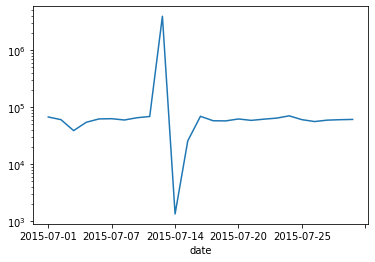

In [15]:
outlierdat=data[(data['fips_state_code'] == 54)&(data['station_id'] == '000050')&(data['month_of_data'] == 7)]
# selecting only the month of july for station 50 in state 54.
ax=outlierdat.groupby('date').sum().iloc[:,8:-1].sum(axis=1).plot(logy=True)

In [16]:
dropidx.extend(data[(data['fips_state_code'] == 54)&(data['station_id'] == '000050')&(data['date'] == '2015-07-13')].index.to_list())
# extend drop index list
data[(data['fips_state_code'] == 54)&(data['station_id'] == '000050')&(data['date'] == '2015-07-13')]
# show only the period where 99999 occurs

,date,day_of_data,day_of_week,direction_of_travel,direction_of_travel_name,fips_state_code,functional_classification,functional_classification_name,lane_of_travel,month_of_data,record_type,restrictions,station_id,traffic_volume_counted_after_0000_to_0100,traffic_volume_counted_after_0100_to_0200,traffic_volume_counted_after_0200_to_0300,traffic_volume_counted_after_0300_to_0400,traffic_volume_counted_after_0400_to_0500,traffic_volume_counted_after_0500_to_0600,traffic_volume_counted_after_0600_to_0700,traffic_volume_counted_after_0700_to_0800,traffic_volume_counted_after_0800_to_0900,traffic_volume_counted_after_0900_to_1000,traffic_volume_counted_after_1000_to_1100,traffic_volume_counted_after_1100_to_1200,traffic_volume_counted_after_1200_to_1300,traffic_volume_counted_after_1300_to_1400,traffic_volume_counted_after_1400_to_1500,traffic_volume_counted_after_1500_to_1600,traffic_volume_counted_after_1600_to_1700,traffic_volume_counted_after_1700_to_1800,traffic_volume_counted_after_1800_to_1900,traffic_volume_counted_after_1900_to_2000,traffic_volume_counted_after_2000_to_2100,traffic_volume_counted_after_2100_to_2200,traffic_volume_counted_after_2200_to_2300,traffic_volume_counted_after_2300_to_2400,year_of_data
502567,2015-07-13,13,2,1,North,54,1R,Rural: Principal Arterial - Interstate,2,7,3,NaN,000050,99,85,76,69,104,243,453,698,773,686,751,783,855,829,99999,99999,99999,99999,99999,99999,99999,99999,99999,99999,15
2608226,2015-07-13,13,2,1,North,54,1R,Rural: Principal Arterial - Interstate,1,7,3,NaN,000050,260,235,227,236,283,457,635,785,857,818,882,917,1003,1033,99999,99999,99999,99999,99999,99999,99999,99999,99999,99999,15
3060890,2015-07-13,13,2,5,South,54,1R,Rural: Principal Arterial - Interstate,2,7,3,NaN,000050,82,70,49,59,104,277,453,628,670,693,788,774,857,895,99999,99999,99999,99999,99999,99999,99999,99999,99999,99999,15
5855121,2015-07-13,13,2,5,South,54,1R,Rural: Principal Arterial - Interstate,1,7,3,NaN,000050,213,200,139,174,240,439,564,706,668,748,807,894,905,923,935,99999,99999,99999,99999,99999,99999,99999,99999,99999,15


The remaining points at the 99999 limit also appear to be one-off errors, and should be dropped.

In [17]:
dropDat=data.drop(index=dropidx)
# loop through all columns and show the dataframe if there are rows hitting the max limit.
def showRemain(dropDat):
    for col in trafficVolCol:
        limitRows=dropDat[dropDat[col]== 99999]
#         only choose 99999
        print(f'In {col} there are {len(limitRows)} points at 99999')
        if len(limitRows)>0:
#             only display if 99999 present
            display(limitRows)
            dropidx.extend(limitRows.index.to_list())
showRemain(dropDat)

In traffic_volume_counted_after_0000_to_0100 there are 6 points at 99999


,date,day_of_data,day_of_week,direction_of_travel,direction_of_travel_name,fips_state_code,functional_classification,functional_classification_name,lane_of_travel,month_of_data,record_type,restrictions,station_id,traffic_volume_counted_after_0000_to_0100,traffic_volume_counted_after_0100_to_0200,traffic_volume_counted_after_0200_to_0300,traffic_volume_counted_after_0300_to_0400,traffic_volume_counted_after_0400_to_0500,traffic_volume_counted_after_0500_to_0600,traffic_volume_counted_after_0600_to_0700,traffic_volume_counted_after_0700_to_0800,traffic_volume_counted_after_0800_to_0900,traffic_volume_counted_after_0900_to_1000,traffic_volume_counted_after_1000_to_1100,traffic_volume_counted_after_1100_to_1200,traffic_volume_counted_after_1200_to_1300,traffic_volume_counted_after_1300_to_1400,traffic_volume_counted_after_1400_to_1500,traffic_volume_counted_after_1500_to_1600,traffic_volume_counted_after_1600_to_1700,traffic_volume_counted_after_1700_to_1800,traffic_volume_counted_after_1800_to_1900,traffic_volume_counted_after_1900_to_2000,traffic_volume_counted_after_2000_to_2100,traffic_volume_counted_after_2100_to_2200,traffic_volume_counted_after_2200_to_2300,traffic_volume_counted_after_2300_to_2400,year_of_data
815383,2015-01-27,27,3,3,East,13,1U,Urban: Principal Arterial - Interstate,3,1,3,NaN,000213,99999,93,97,116,193,361,724,1206,1251,712,686,626,670,670,758,794,782,806,543,477,335,326,209,191,15
1162143,2015-06-03,3,4,5,South,13,1U,Urban: Principal Arterial - Interstate,1,6,3,NaN,000110,99999,147,116,141,149,238,374,446,463,434,458,490,551,576,621,629,593,587,484,438,449,323,229,195,15
1856191,2015-06-03,3,4,5,South,13,1U,Urban: Principal Arterial - Interstate,3,6,3,NaN,000110,99999,33,17,26,38,82,221,355,311,234,297,335,346,414,541,595,504,400,238,259,252,174,108,82,15
1981984,2015-01-27,27,3,7,West,13,1U,Urban: Principal Arterial - Interstate,3,1,3,NaN,000213,99999,27,15,32,51,121,328,745,590,431,458,521,521,560,747,898,1195,1244,663,380,214,261,117,372,15
4087633,2015-01-27,27,3,7,West,13,1U,Urban: Principal Arterial - Interstate,2,1,3,NaN,000213,99999,154,158,185,286,531,902,1471,1306,1099,1229,1177,1271,1229,1437,1495,1631,1693,1245,928,671,668,483,363,15
5658279,2015-01-27,27,3,3,East,13,1U,Urban: Principal Arterial - Interstate,4,1,3,NaN,000213,99999,46,58,51,117,208,496,1124,1064,605,510,536,647,568,553,572,610,766,465,339,233,220,141,247,15


In traffic_volume_counted_after_0100_to_0200 there are 0 points at 99999
In traffic_volume_counted_after_0200_to_0300 there are 0 points at 99999
In traffic_volume_counted_after_0300_to_0400 there are 0 points at 99999
In traffic_volume_counted_after_0400_to_0500 there are 0 points at 99999
In traffic_volume_counted_after_0500_to_0600 there are 0 points at 99999
In traffic_volume_counted_after_0600_to_0700 there are 0 points at 99999
In traffic_volume_counted_after_0700_to_0800 there are 0 points at 99999
In traffic_volume_counted_after_0800_to_0900 there are 4 points at 99999


,date,day_of_data,day_of_week,direction_of_travel,direction_of_travel_name,fips_state_code,functional_classification,functional_classification_name,lane_of_travel,month_of_data,record_type,restrictions,station_id,traffic_volume_counted_after_0000_to_0100,traffic_volume_counted_after_0100_to_0200,traffic_volume_counted_after_0200_to_0300,traffic_volume_counted_after_0300_to_0400,traffic_volume_counted_after_0400_to_0500,traffic_volume_counted_after_0500_to_0600,traffic_volume_counted_after_0600_to_0700,traffic_volume_counted_after_0700_to_0800,traffic_volume_counted_after_0800_to_0900,traffic_volume_counted_after_0900_to_1000,traffic_volume_counted_after_1000_to_1100,traffic_volume_counted_after_1100_to_1200,traffic_volume_counted_after_1200_to_1300,traffic_volume_counted_after_1300_to_1400,traffic_volume_counted_after_1400_to_1500,traffic_volume_counted_after_1500_to_1600,traffic_volume_counted_after_1600_to_1700,traffic_volume_counted_after_1700_to_1800,traffic_volume_counted_after_1800_to_1900,traffic_volume_counted_after_1900_to_2000,traffic_volume_counted_after_2000_to_2100,traffic_volume_counted_after_2100_to_2200,traffic_volume_counted_after_2200_to_2300,traffic_volume_counted_after_2300_to_2400,year_of_data
1332255,2015-06-23,23,3,3,East,13,1R,Rural: Principal Arterial - Interstate,2,6,3,NaN,000172,0,0,0,0,0,0,0,0,99999,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15
3870173,2015-06-23,23,3,3,East,13,1R,Rural: Principal Arterial - Interstate,1,6,3,NaN,000172,0,0,0,0,0,0,0,0,99999,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15
5086973,2015-06-23,23,3,7,West,13,1R,Rural: Principal Arterial - Interstate,2,6,3,NaN,000172,0,0,0,0,0,0,0,0,99999,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15
5801572,2015-06-23,23,3,7,West,13,1R,Rural: Principal Arterial - Interstate,1,6,3,NaN,000172,0,0,0,0,0,0,0,0,99999,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15


In traffic_volume_counted_after_0900_to_1000 there are 0 points at 99999
In traffic_volume_counted_after_1000_to_1100 there are 3 points at 99999


,date,day_of_data,day_of_week,direction_of_travel,direction_of_travel_name,fips_state_code,functional_classification,functional_classification_name,lane_of_travel,month_of_data,record_type,restrictions,station_id,traffic_volume_counted_after_0000_to_0100,traffic_volume_counted_after_0100_to_0200,traffic_volume_counted_after_0200_to_0300,traffic_volume_counted_after_0300_to_0400,traffic_volume_counted_after_0400_to_0500,traffic_volume_counted_after_0500_to_0600,traffic_volume_counted_after_0600_to_0700,traffic_volume_counted_after_0700_to_0800,traffic_volume_counted_after_0800_to_0900,traffic_volume_counted_after_0900_to_1000,traffic_volume_counted_after_1000_to_1100,traffic_volume_counted_after_1100_to_1200,traffic_volume_counted_after_1200_to_1300,traffic_volume_counted_after_1300_to_1400,traffic_volume_counted_after_1400_to_1500,traffic_volume_counted_after_1500_to_1600,traffic_volume_counted_after_1600_to_1700,traffic_volume_counted_after_1700_to_1800,traffic_volume_counted_after_1800_to_1900,traffic_volume_counted_after_1900_to_2000,traffic_volume_counted_after_2000_to_2100,traffic_volume_counted_after_2100_to_2200,traffic_volume_counted_after_2200_to_2300,traffic_volume_counted_after_2300_to_2400,year_of_data
2583136,2015-02-02,2,2,1,North,13,1U,Urban: Principal Arterial - Interstate,1,2,3,NaN,000022,78,67,69,86,97,151,230,427,380,387,99999,439,530,451,452,519,527,573,446,338,264,215,192,142,15
6807760,2015-02-02,2,2,1,North,13,1U,Urban: Principal Arterial - Interstate,2,2,3,NaN,000022,83,55,50,60,64,112,189,353,381,456,99999,594,625,560,532,584,653,587,383,329,234,192,140,106,15
6995595,2015-02-02,2,2,1,North,13,1U,Urban: Principal Arterial - Interstate,3,2,3,NaN,000022,16,9,11,10,3,16,52,130,128,164,99999,265,271,220,230,295,322,322,184,105,58,57,35,16,15


In traffic_volume_counted_after_1100_to_1200 there are 0 points at 99999
In traffic_volume_counted_after_1200_to_1300 there are 9 points at 99999


,date,day_of_data,day_of_week,direction_of_travel,direction_of_travel_name,fips_state_code,functional_classification,functional_classification_name,lane_of_travel,month_of_data,record_type,restrictions,station_id,traffic_volume_counted_after_0000_to_0100,traffic_volume_counted_after_0100_to_0200,traffic_volume_counted_after_0200_to_0300,traffic_volume_counted_after_0300_to_0400,traffic_volume_counted_after_0400_to_0500,traffic_volume_counted_after_0500_to_0600,traffic_volume_counted_after_0600_to_0700,traffic_volume_counted_after_0700_to_0800,traffic_volume_counted_after_0800_to_0900,traffic_volume_counted_after_0900_to_1000,traffic_volume_counted_after_1000_to_1100,traffic_volume_counted_after_1100_to_1200,traffic_volume_counted_after_1200_to_1300,traffic_volume_counted_after_1300_to_1400,traffic_volume_counted_after_1400_to_1500,traffic_volume_counted_after_1500_to_1600,traffic_volume_counted_after_1600_to_1700,traffic_volume_counted_after_1700_to_1800,traffic_volume_counted_after_1800_to_1900,traffic_volume_counted_after_1900_to_2000,traffic_volume_counted_after_2000_to_2100,traffic_volume_counted_after_2100_to_2200,traffic_volume_counted_after_2200_to_2300,traffic_volume_counted_after_2300_to_2400,year_of_data
5126,2015-08-31,31,2,1,North,13,3U,Urban: Principal Arterial - Other,1,8,3,NaN,000260,8,7,2,9,17,42,500,143,142,131,124,151,99999,147,173,230,222,253,179,113,84,52,22,1774,15
1110856,2015-06-29,29,2,1,North,13,3U,Urban: Principal Arterial - Other,2,6,3,NaN,000260,10,7,3,9,719,23,49,75,89,111,114,119,99999,135,148,152,197,217,118,82,57,46,34,3313,15
2793141,2015-09-18,18,6,1,North,13,3U,Urban: Principal Arterial - Other,1,9,3,NaN,000260,15,9,14,14,13,42,90,140,141,150,159,156,99999,189,218,262,275,239,180,160,119,74,67,165,15
3520276,2015-06-29,29,2,1,North,13,3U,Urban: Principal Arterial - Other,1,6,3,NaN,000260,17,8,10,11,427,32,86,114,144,121,152,174,99999,157,181,216,241,272,169,125,72,75,53,1856,15
6049722,2015-09-18,18,6,1,North,13,3U,Urban: Principal Arterial - Other,2,9,3,NaN,000260,7,10,10,8,26,26,53,101,117,106,122,138,99999,162,173,215,213,224,164,139,84,66,48,302,15
6119018,2015-09-18,18,6,5,South,13,3U,Urban: Principal Arterial - Other,1,9,3,NaN,000260,25,17,15,10,42,102,210,310,201,187,202,183,99999,191,215,211,201,195,160,159,94,76,70,143,15
6119155,2015-08-31,31,2,5,South,13,3U,Urban: Principal Arterial - Other,1,8,3,NaN,000260,17,10,12,18,40,94,618,348,198,176,193,149,99999,202,186,167,191,187,122,109,89,52,30,971,15
6133242,2015-06-29,29,2,5,South,13,3U,Urban: Principal Arterial - Other,1,6,3,NaN,000260,20,12,11,12,436,104,188,272,197,168,189,158,99999,170,192,186,186,182,142,116,68,82,42,988,15
6570691,2015-08-31,31,2,1,North,13,3U,Urban: Principal Arterial - Other,2,8,3,NaN,000260,15,9,5,4,16,30,765,108,95,102,96,129,99999,122,136,196,178,200,132,105,85,46,17,3092,15


In traffic_volume_counted_after_1300_to_1400 there are 0 points at 99999
In traffic_volume_counted_after_1400_to_1500 there are 0 points at 99999
In traffic_volume_counted_after_1500_to_1600 there are 0 points at 99999
In traffic_volume_counted_after_1600_to_1700 there are 0 points at 99999
In traffic_volume_counted_after_1700_to_1800 there are 0 points at 99999
In traffic_volume_counted_after_1800_to_1900 there are 0 points at 99999
In traffic_volume_counted_after_1900_to_2000 there are 0 points at 99999
In traffic_volume_counted_after_2000_to_2100 there are 0 points at 99999
In traffic_volume_counted_after_2100_to_2200 there are 2 points at 99999


,date,day_of_data,day_of_week,direction_of_travel,direction_of_travel_name,fips_state_code,functional_classification,functional_classification_name,lane_of_travel,month_of_data,record_type,restrictions,station_id,traffic_volume_counted_after_0000_to_0100,traffic_volume_counted_after_0100_to_0200,traffic_volume_counted_after_0200_to_0300,traffic_volume_counted_after_0300_to_0400,traffic_volume_counted_after_0400_to_0500,traffic_volume_counted_after_0500_to_0600,traffic_volume_counted_after_0600_to_0700,traffic_volume_counted_after_0700_to_0800,traffic_volume_counted_after_0800_to_0900,traffic_volume_counted_after_0900_to_1000,traffic_volume_counted_after_1000_to_1100,traffic_volume_counted_after_1100_to_1200,traffic_volume_counted_after_1200_to_1300,traffic_volume_counted_after_1300_to_1400,traffic_volume_counted_after_1400_to_1500,traffic_volume_counted_after_1500_to_1600,traffic_volume_counted_after_1600_to_1700,traffic_volume_counted_after_1700_to_1800,traffic_volume_counted_after_1800_to_1900,traffic_volume_counted_after_1900_to_2000,traffic_volume_counted_after_2000_to_2100,traffic_volume_counted_after_2100_to_2200,traffic_volume_counted_after_2200_to_2300,traffic_volume_counted_after_2300_to_2400,year_of_data
2430562,2015-02-04,4,4,3,East,13,4U,Urban: Minor Arterial,1,2,3,NaN,000079,21,13,9,11,26,86,257,333,306,262,294,362,406,403,372,375,389,386,345,246,189,99999,76,186,15
6297705,2015-02-04,4,4,7,West,13,4U,Urban: Minor Arterial,2,2,3,NaN,000079,44,27,18,24,46,80,120,267,301,356,371,427,497,517,467,581,714,748,511,362,249,99999,127,171,15


In traffic_volume_counted_after_2200_to_2300 there are 0 points at 99999
In traffic_volume_counted_after_2300_to_2400 there are 3 points at 99999


,date,day_of_data,day_of_week,direction_of_travel,direction_of_travel_name,fips_state_code,functional_classification,functional_classification_name,lane_of_travel,month_of_data,record_type,restrictions,station_id,traffic_volume_counted_after_0000_to_0100,traffic_volume_counted_after_0100_to_0200,traffic_volume_counted_after_0200_to_0300,traffic_volume_counted_after_0300_to_0400,traffic_volume_counted_after_0400_to_0500,traffic_volume_counted_after_0500_to_0600,traffic_volume_counted_after_0600_to_0700,traffic_volume_counted_after_0700_to_0800,traffic_volume_counted_after_0800_to_0900,traffic_volume_counted_after_0900_to_1000,traffic_volume_counted_after_1000_to_1100,traffic_volume_counted_after_1100_to_1200,traffic_volume_counted_after_1200_to_1300,traffic_volume_counted_after_1300_to_1400,traffic_volume_counted_after_1400_to_1500,traffic_volume_counted_after_1500_to_1600,traffic_volume_counted_after_1600_to_1700,traffic_volume_counted_after_1700_to_1800,traffic_volume_counted_after_1800_to_1900,traffic_volume_counted_after_1900_to_2000,traffic_volume_counted_after_2000_to_2100,traffic_volume_counted_after_2100_to_2200,traffic_volume_counted_after_2200_to_2300,traffic_volume_counted_after_2300_to_2400,year_of_data
345918,2015-02-26,26,5,3,East,13,1U,Urban: Principal Arterial - Interstate,2,2,3,NaN,000094,38,719,13,42,125,360,705,1019,715,659,749,862,843,940,1183,1416,1603,1545,1124,854,610,363,195,99999,15
3060235,2015-02-26,26,5,7,West,13,1U,Urban: Principal Arterial - Interstate,1,2,3,NaN,000094,91,390,71,70,186,625,1100,1316,1159,1070,957,949,1013,969,999,1022,1121,1149,798,580,390,318,241,99999,15
4812542,2015-02-26,26,5,3,East,13,1U,Urban: Principal Arterial - Interstate,1,2,3,NaN,000094,133,4622,75,103,243,453,679,913,713,769,836,919,925,997,1142,1318,1482,1488,1131,892,674,536,310,99999,15


Now moving on to the negative values, we observed previously that there was an extremely large negative value reported for traffic_volume_counted_after_1200_to_1300.

Looking into this particular row, we see that again, we may have some data quality issues. The traffic volumes for the times surrounding 12 PM to 1 PM show disturbances, with sudden jumps between high and low volume. The reported volume for this day is also much higher than the baseline for this particular month. 

As such, this should be omitted as well.

In [18]:
dropidx.append(6485860)
data.sort_values('traffic_volume_counted_after_1200_to_1300').head(1)


,date,day_of_data,day_of_week,direction_of_travel,direction_of_travel_name,fips_state_code,functional_classification,functional_classification_name,lane_of_travel,month_of_data,record_type,restrictions,station_id,traffic_volume_counted_after_0000_to_0100,traffic_volume_counted_after_0100_to_0200,traffic_volume_counted_after_0200_to_0300,traffic_volume_counted_after_0300_to_0400,traffic_volume_counted_after_0400_to_0500,traffic_volume_counted_after_0500_to_0600,traffic_volume_counted_after_0600_to_0700,traffic_volume_counted_after_0700_to_0800,traffic_volume_counted_after_0800_to_0900,traffic_volume_counted_after_0900_to_1000,traffic_volume_counted_after_1000_to_1100,traffic_volume_counted_after_1100_to_1200,traffic_volume_counted_after_1200_to_1300,traffic_volume_counted_after_1300_to_1400,traffic_volume_counted_after_1400_to_1500,traffic_volume_counted_after_1500_to_1600,traffic_volume_counted_after_1600_to_1700,traffic_volume_counted_after_1700_to_1800,traffic_volume_counted_after_1800_to_1900,traffic_volume_counted_after_1900_to_2000,traffic_volume_counted_after_2000_to_2100,traffic_volume_counted_after_2100_to_2200,traffic_volume_counted_after_2200_to_2300,traffic_volume_counted_after_2300_to_2400,year_of_data
6485860,2015-03-07,7,7,1,North,55,1R,Rural: Principal Arterial - Interstate,1,3,3,NaN,051139,94,84,56,63,116,201,306,351,478,640,704,675,-3061,80064,7,90009,30029,53,60049,80032,29,70024,40020,80013,15


<AxesSubplot:xlabel='date'>

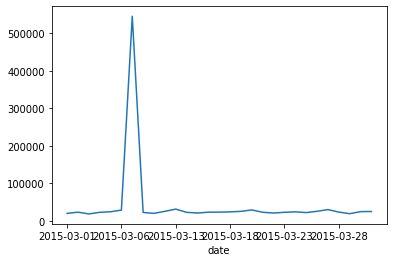

In [19]:
data[(data['fips_state_code'] == 55)&(data['station_id'] == '051139')&(data['month_of_data'] == 3)].groupby('date').sum().iloc[:,8:-1].sum(axis=1).plot()

After discarding the anomalous data, it is observed that the general shape of the distributions in traffic remain relatively similar.

This is due to the large overall traffic volumes for the impacted road classifcations. (except Urban: Local System)

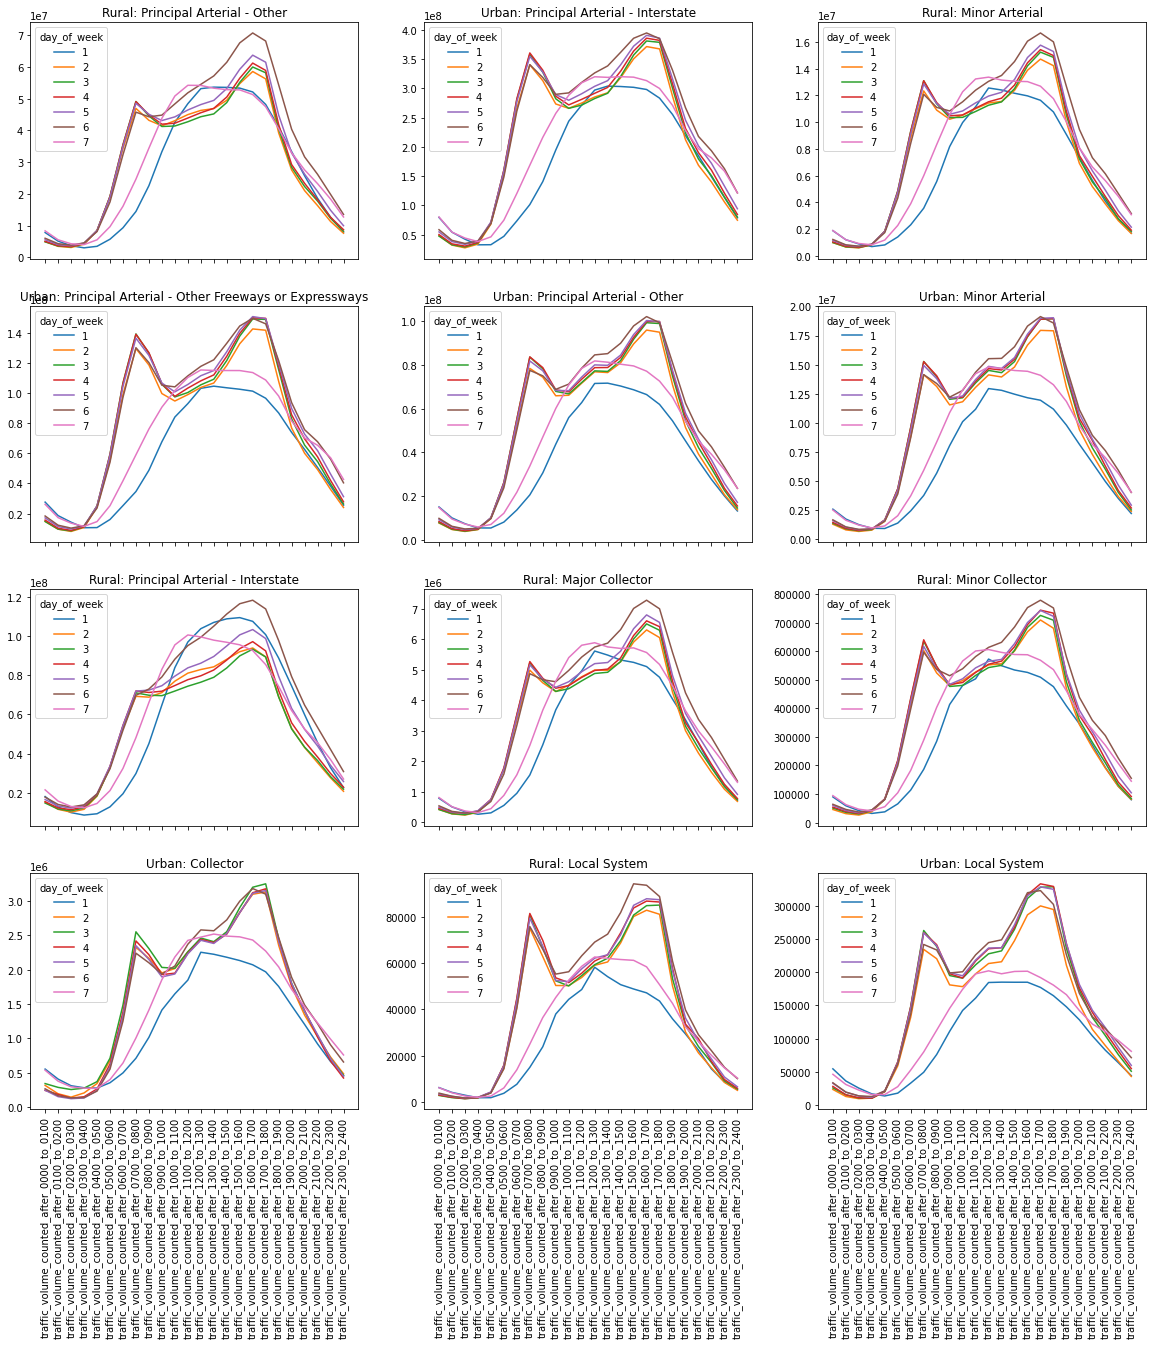

In [20]:
dropDat=data.drop(index=dropidx)
trafficsub(dropDat)

**Modeling**

In this section, I attempt to make some simple models using the available data. 

The focus will be on linear regression, as it is most easily deployable and understood by various systems and people.

I decided to look at pairwise correlations between various time bins, focusing only on weekdays, since weekends present a different traffic volume distribution.

It is noted that the current time bin appears to be strongly related linearly to the next, as indicated by the high Pearson coefficient. 

This trend however is not the same for the last time bin from 11PM to 12AM, as its correlation coefficients are much weaker across the board.

In [21]:
weekDat=dropDat[(dropDat['day_of_week']!=1)&(dropDat['day_of_week']!=7)][trafficVolCol]
# select only the traffic volume columns and only weekdays
weekDat.rename(columns=lambda x: x[-4:]).corr().style.background_gradient(cmap='coolwarm').format(precision=3)

,0100,0200,0300,0400,0500,0600,0700,0800,0900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000,2100,2200,2300,2400
0100,1.000,0.926,0.869,0.834,0.761,0.684,0.661,0.625,0.632,0.659,0.664,0.663,0.649,0.646,0.633,0.620,0.608,0.604,0.613,0.599,0.573,0.548,0.517,0.422
0200,0.926,1.000,0.947,0.889,0.741,0.608,0.559,0.507,0.510,0.535,0.541,0.538,0.526,0.522,0.508,0.493,0.484,0.483,0.494,0.486,0.470,0.456,0.443,0.374
0300,0.869,0.947,1.000,0.941,0.762,0.613,0.550,0.488,0.487,0.508,0.514,0.510,0.497,0.493,0.477,0.462,0.454,0.454,0.463,0.453,0.440,0.429,0.420,0.359
0400,0.834,0.889,0.941,1.000,0.870,0.710,0.622,0.548,0.544,0.563,0.563,0.554,0.539,0.532,0.515,0.498,0.488,0.487,0.490,0.476,0.461,0.449,0.431,0.359
0500,0.761,0.741,0.762,0.870,1.000,0.909,0.796,0.706,0.699,0.723,0.707,0.694,0.673,0.668,0.650,0.629,0.611,0.601,0.602,0.571,0.542,0.515,0.467,0.365
0600,0.684,0.608,0.613,0.710,0.909,1.000,0.938,0.844,0.832,0.842,0.813,0.795,0.771,0.765,0.750,0.733,0.714,0.702,0.695,0.649,0.604,0.563,0.496,0.367
0700,0.661,0.559,0.550,0.622,0.796,0.938,1.000,0.949,0.925,0.907,0.869,0.853,0.831,0.824,0.815,0.809,0.796,0.783,0.761,0.699,0.644,0.592,0.516,0.375
0800,0.625,0.507,0.488,0.548,0.706,0.844,0.949,1.000,0.969,0.932,0.894,0.877,0.858,0.851,0.848,0.848,0.844,0.827,0.794,0.723,0.661,0.613,0.530,0.391
0900,0.632,0.510,0.487,0.544,0.699,0.832,0.925,0.969,1.000,0.955,0.920,0.901,0.882,0.876,0.870,0.868,0.861,0.846,0.821,0.750,0.690,0.638,0.557,0.415
1000,0.659,0.535,0.508,0.563,0.723,0.842,0.907,0.932,0.955,1.000,0.956,0.937,0.910,0.906,0.896,0.881,0.867,0.850,0.838,0.778,0.729,0.669,0.588,0.448


Taking 10% of the dataset from the 12PM to 1PM bin, we see that the values span many orders of magnitude. We do not see an obvious linear trend with many values scattered everywhere. 

As such a loglog plot is also performed, to give more visibility to smaller values. A somewhat linear trend is observed.

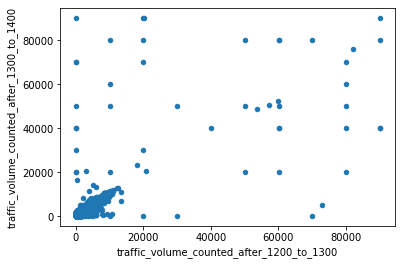

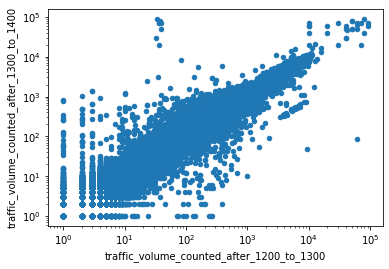

In [22]:
ax=weekDat.sample(700000).plot.scatter(x='traffic_volume_counted_after_1200_to_1300',y='traffic_volume_counted_after_1300_to_1400')

ax=weekDat.sample(700000).plot.scatter(x='traffic_volume_counted_after_1200_to_1300',y='traffic_volume_counted_after_1300_to_1400',loglog=True)

Hence, the pariwise linear correlations were also examined for the log traffic volumes. 

In this case, we have to add 2 to all the colmns, to prevent any error in computing the natural logaritm, as we know from previously, we have traffic volumes starting at -1.

Impressively, this simple transform seems the improve the correlation between adjacent time bins.

We also see a significant increase in the correlation coefficient (up to ~0.8) for time bins much further out. This suggests that we may be able to do some simple chaining of models together to derive an entire distribution, similar to a markov chain.

In [23]:
np.log(2+weekDat).rename(columns=lambda x: x[-4:]).corr().style.background_gradient(cmap='coolwarm').format(precision=3)

,0100,0200,0300,0400,0500,0600,0700,0800,0900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000,2100,2200,2300,2400
0100,1.000,0.961,0.939,0.905,0.855,0.809,0.789,0.781,0.821,0.852,0.862,0.865,0.865,0.866,0.860,0.848,0.838,0.839,0.870,0.893,0.904,0.915,0.929,0.940
0200,0.961,1.000,0.957,0.926,0.868,0.809,0.774,0.757,0.796,0.830,0.841,0.842,0.838,0.838,0.831,0.815,0.802,0.801,0.834,0.861,0.874,0.886,0.903,0.919
0300,0.939,0.957,1.000,0.948,0.895,0.829,0.783,0.757,0.790,0.823,0.832,0.830,0.824,0.824,0.816,0.798,0.784,0.780,0.812,0.838,0.851,0.864,0.882,0.897
0400,0.905,0.926,0.948,1.000,0.944,0.884,0.829,0.789,0.811,0.837,0.840,0.833,0.823,0.823,0.815,0.796,0.780,0.774,0.801,0.823,0.835,0.846,0.859,0.868
0500,0.855,0.868,0.895,0.944,1.000,0.952,0.899,0.850,0.856,0.866,0.860,0.848,0.836,0.835,0.827,0.810,0.795,0.787,0.806,0.819,0.827,0.833,0.838,0.834
0600,0.809,0.809,0.829,0.884,0.952,1.000,0.961,0.917,0.907,0.896,0.880,0.865,0.852,0.851,0.846,0.834,0.822,0.816,0.826,0.828,0.830,0.832,0.828,0.811
0700,0.789,0.774,0.783,0.829,0.899,0.961,1.000,0.968,0.949,0.923,0.900,0.885,0.874,0.871,0.870,0.864,0.857,0.854,0.857,0.848,0.844,0.842,0.832,0.807
0800,0.781,0.757,0.757,0.789,0.850,0.917,0.968,1.000,0.973,0.939,0.915,0.901,0.891,0.887,0.886,0.885,0.881,0.880,0.878,0.864,0.856,0.850,0.836,0.809
0900,0.821,0.796,0.790,0.811,0.856,0.907,0.949,0.973,1.000,0.970,0.949,0.936,0.926,0.921,0.917,0.912,0.906,0.904,0.909,0.898,0.891,0.885,0.871,0.846
1000,0.852,0.830,0.823,0.837,0.866,0.896,0.923,0.939,0.970,1.000,0.981,0.969,0.957,0.952,0.945,0.934,0.924,0.919,0.928,0.923,0.916,0.910,0.897,0.874


Let's do a test with data from 12PM to 1PM.

First, we split the data set into training and test sets, after applying the natural log transformation.

Using the default test size of 25%

Then we train the linear model on the training set.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(np.log(2+weekDat['traffic_volume_counted_after_1200_to_1300'].to_numpy().reshape(-1,1)),np.log(2+weekDat['traffic_volume_counted_after_1300_to_1400'].to_numpy()))
reg=LinearRegression().fit(X_train,y_train)

Next we test the model against the test set, and plot out the best fit line against a scatter of true values.


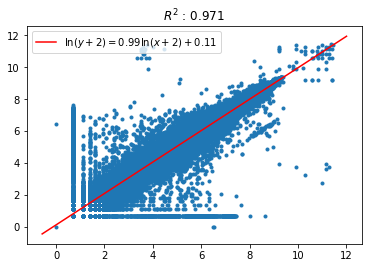

In [25]:
def sampleplot(reg,xtest,ytest,binname,ax):
    ax.plot(xtest,ytest,'.')
#     plot raw test data
    xrange=np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],30).reshape(-1,1)
    ax.plot(xrange,reg.predict(xrange),'r',label=f'$\\ln(y+2)={reg.coef_[0]:.2f} \\ln(x+2) +{reg.intercept_:.2f}$')
#     plot regression line
    ax.title.set_text(f'$R^2$ : {reg.score(xtest,ytest):.3f}')
    ax.legend(loc='upper left')

sampleplot(reg,X_test,y_test,'traffic_volume_counted_after_1200_to_1300',plt.subplots(1,1)[1])

Applying the same process to the rest of the hourly bins:

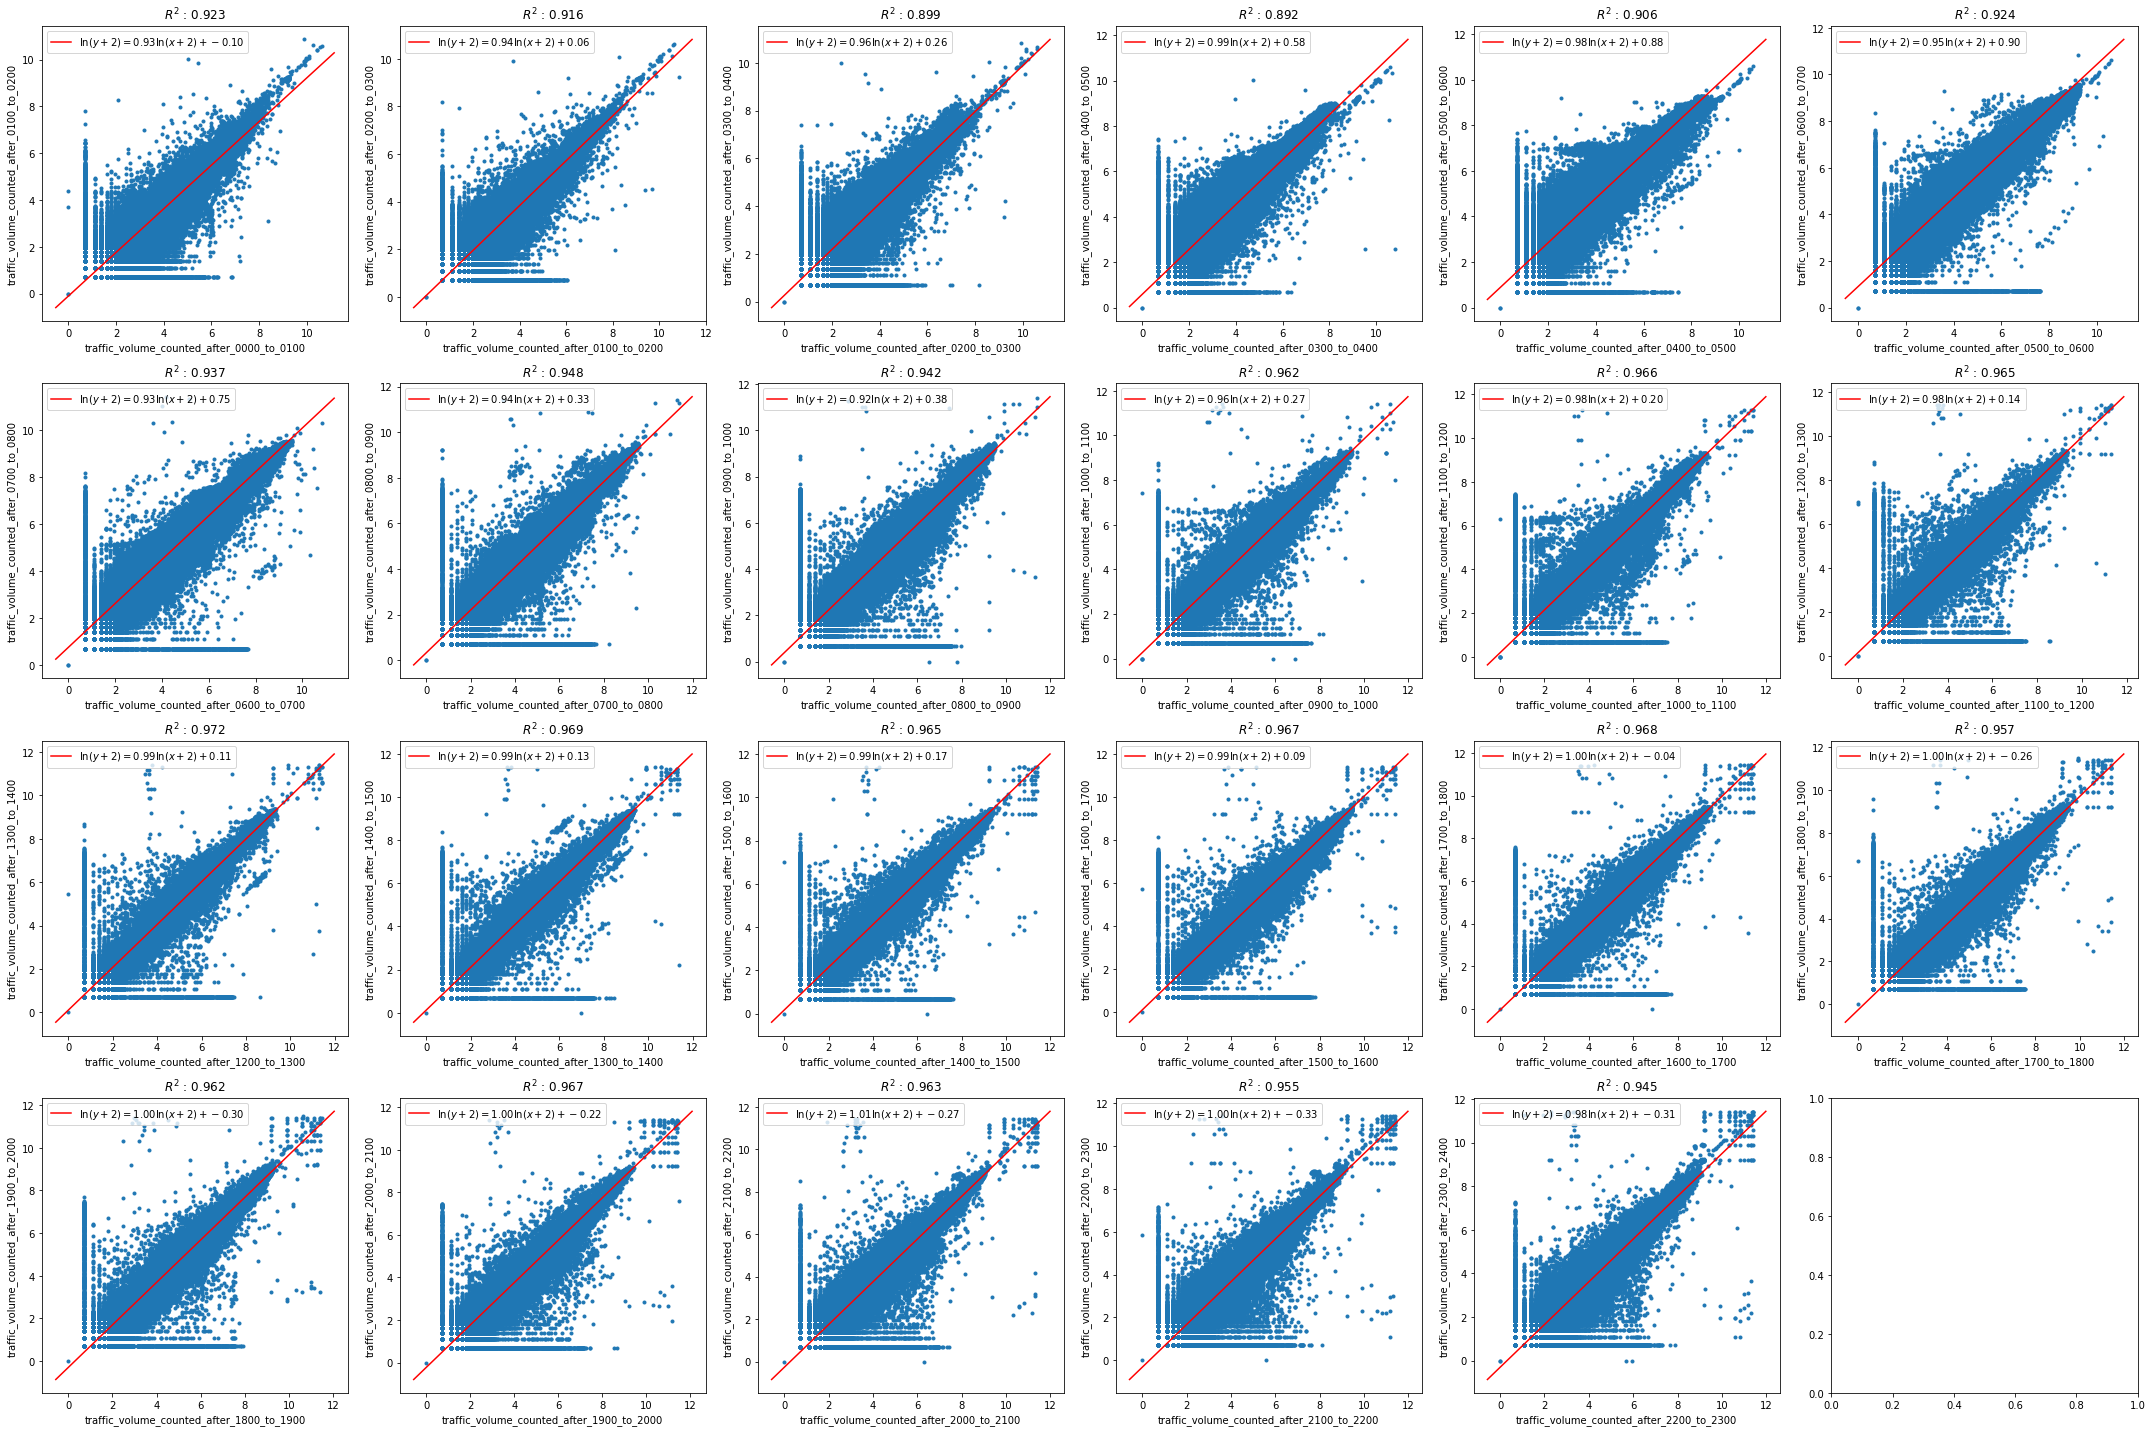

In [26]:
def regLoop(data):
    regModels=[]
    fig,axs=plt.subplots(4,6,figsize=(30,20))
    for idx,startcol in enumerate(trafficVolCol[:-1]):
#         stop at 2nd last object
        nextcol=trafficVolCol[idx+1]
        pltax=axs.flat[idx]
        pltax.set_xlabel(startcol)
        pltax.set_ylabel(nextcol)
#         set axis labels
        X_train, X_test, y_train, y_test = train_test_split(np.log(2+data[startcol].to_numpy().reshape(-1,1)),np.log(2+data[nextcol].to_numpy()), random_state=0)
        reg=LinearRegression().fit(X_train,y_train)
#         split and train model
        sampleplot(reg,X_test,y_test,startcol,pltax)
#     plot test
        regModels.append(reg)
#     retain models for future use
    plt.tight_layout()
    plt.show()
    return regModels
regModels=regLoop(weekDat)

Chaining the regression models together on a random ground truth sample, we see that we are able to capture the shape, as well as the order of magnitude of the ground truth pretty well. 

While I do not claim this to be perfect and there is still much room for improvement, I believe this stands as a reasonable baseline model to work from.

Intrestingly the model appears to have managed to capture one profile spot on, but the others not so much.



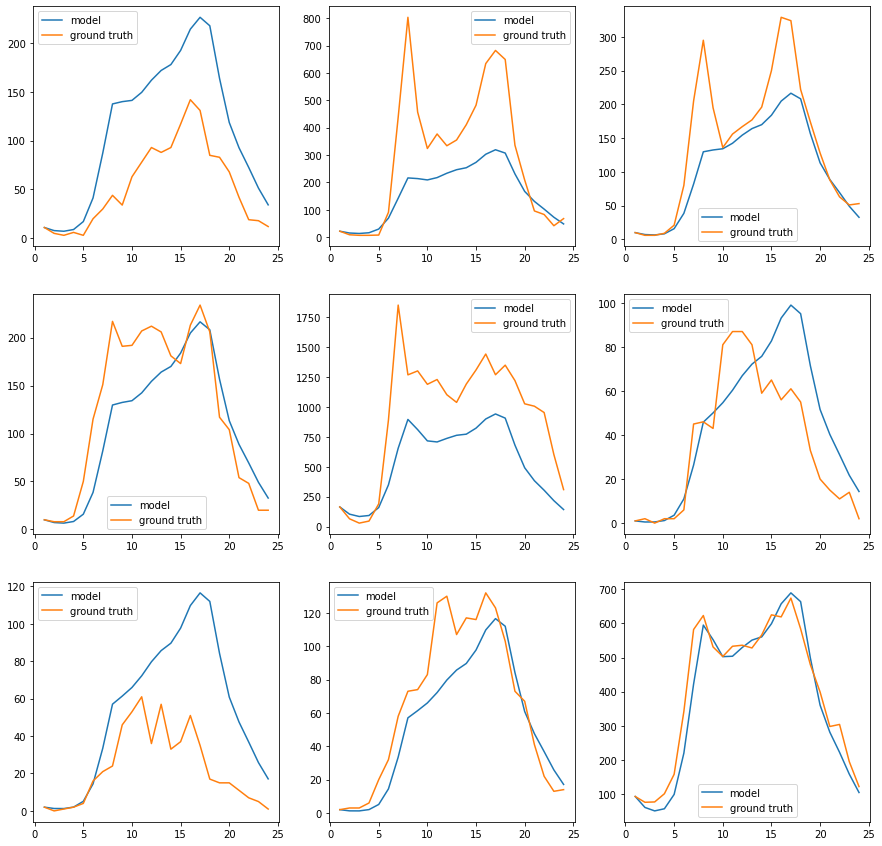

In [27]:
def modelpred(rowDat,ax):
    pred=[np.log(rowDat[0]+2)]

    for x in range(0,23):
        pred.append(regModels[x].predict(pred[x].reshape(1,-1)))
    ax.plot(np.arange(1,25,1),np.exp(pred)-2,label='model')
    ax.plot(np.arange(1,25,1),rowDat,label='ground truth')
    ax.legend()

fig,axs=plt.subplots(3,3,figsize=(15,15))
for row,ax in enumerate(axs.flat):
    rowDat=weekDat.sample(10,random_state=0)
    modelpred(rowDat.iloc[row].to_numpy().reshape(-1,1),ax)

**Conclusion**

In conclusion, the most obvious patterns observed from this dataset are as follows:
1. Weekday traffic follow a bimodal distribution, orresponding to office hours.
2. Weekend traffic volume is more bell shaped, peaking in the afternoon.
3. The traffic volume for Rural Interstate roads appear to deviate from this general trend, without an obvious trough between two peaks.
4. There are a number of anomalous points, most easily identified by the upper limit value of 99999.
5. It appears to be possible to predict traffic volumes reasonably using a natual logaritm transform and simple linear regression. the model definitely struggles,when using the various transition models in a Markov Chain style prediction, but the fidelity of the predictions is not completely lost. 
